In [1]:
# Load and format the MNIST dataset
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

num_train_samples = 60000

with gzip.open('./data/train-images-idx3-ubyte.gz') as gz:
    n = struct.unpack('I', gz.read(4))
    # Read magic number.
    if n[0] != 0x3080000:
        raise Exception('Invalid file: unexpected magic number.')
    # Read number of entries.
    n = struct.unpack('>I', gz.read(4))[0]
    if n != num_train_samples:
        raise Exception('Invalid file: expected {0} entries.'.format(num_train_samples))
    crow = struct.unpack('>I', gz.read(4))[0]
    ccol = struct.unpack('>I', gz.read(4))[0]
    if crow != 28 or ccol != 28:
        raise Exception('Invalid file: expected 28 rows/cols per image.')
    # Read image.
    # Format into 60000*784 array
    train_image = np.frombuffer(gz.read(num_train_samples * crow * ccol), dtype = np.uint8)
    train_image = train_image.reshape((num_train_samples, crow*ccol))
    
with gzip.open('./data/train-labels-idx1-ubyte.gz') as gz:
    n = struct.unpack('I', gz.read(4))
    # Read magic number.
    if n[0] != 0x1080000:
        raise Exception('Invalid file: unexpected magic number.')
    # Read number of entries.
    n = struct.unpack('>I', gz.read(4))
    if n[0] != num_train_samples:
        raise Exception('Invalid file: expected {0} rows.'.format(num_train_samples))
    # Read labels.
    train_labels = np.frombuffer(gz.read(num_train_samples), dtype = np.uint8)

print('Dataset impoerted')

Dataset impoerted


In [2]:
# Normalize the input features
norm_data = np.zeros((60000,784))
for i in range(train_image.shape[1]):
    mean = np.mean(train_image[:,i])
    std = np.std(train_image[:,i])
    if(std != 0):
        norm_data[:,i] =  (train_image[:,i] - mean)/std

# Add a bias variable by concatenatting ones to the dataset
input = np.hstack((norm_data, np.ones((60000,1))))

# Convert labels into binary form
binary_labels = np.zeros((60000))
for i in range(train_labels.shape[0]):
    if(train_labels[i]>4):
        binary_labels[i] = 1
binary_labels = binary_labels.astype(int)

print('Data normalization done')

Data normalization done


When batch size=100, t=1000, learning rate=1e-7
Final accuracy:77.22%
Final loss:0.499649


Text(0, 0.5, 'loss')

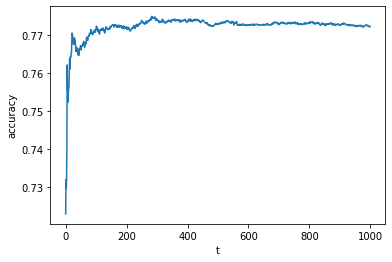

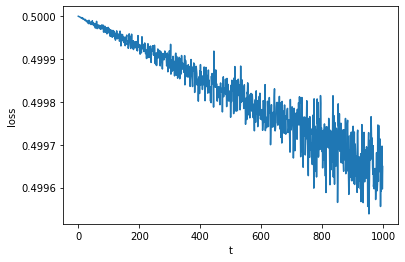

In [3]:
# Linear classifier
import matplotlib.pyplot as plt

def linear_classifier(W, X, y_oh, B, N, ITR, lr):
    acc_W = np.zeros(ITR)
    loss = np.zeros(ITR)
    for iteration in range(ITR):
        G = 0
        # Create a new batch by randomly choice of dataset
        batch_idx = np.random.randint(0, N, size=B)
        X_batch = X[batch_idx]
        y_batch = y_oh[batch_idx]

        # Calculate gradient
        G += np.dot(X_batch.T, (np.dot(X_batch, W.T) - y_batch))
        G = G/B
        
        # Calculate loss
        loss[iteration] = np.sum(np.square(np.dot(X_batch, W.T) - y_batch))/(2*B)
        
        # Update W
        W = W - lr * G.T
        
        # Calculate accuracy of current W
        acc_W[iteration] = acc(W, X[50000:60000,],y_oh[50000:60000,])
    return W, loss, acc_W

# Accuracy update function
def acc(W, X, y):
    cor_W = 0
    for i in range(10000):
        y_hat = np.argmax(np.dot(W, X[i]))
        if( y_hat == np.argmax(y[i])):
            cor_W += 1
    return cor_W/10000


# Initialize parameters
W0 = np.zeros((2, 784))

# Map labels into on-hot form
y_oh = np.zeros((60000, 2))
for i in range(60000):
    y_oh[i, binary_labels[i]] = 1

# Train a linear classifier
w_final, loss, acc_W = linear_classifier(W0, norm_data, y_oh, 100, 50000, 1000, 1e-7)
print('When batch size=100, t=1000, learning rate=1e-7')
print('Final accuracy:%2.2f%%\nFinal loss:%f'%(acc_W[999]*100, loss[999]))
plt.figure()
plt.plot(acc_W)
plt.xlabel('t')
plt.ylabel('accuracy')
plt.figure()
plt.plot(loss)
plt.xlabel('t')
plt.ylabel('loss')

In [106]:
# Neural Net Classifier: quadratic loss and identity activation

# Relu activation function
def ReLU(x):
    return np.maximum(x, 0)

def fx(x, W, v):
    return np.dot(v, ReLU(np.dot(W, x.T)))

def acc(W, v, x, y):
    count = 0
    for i in range(x.shape[0]):
        y_hat = 1 if(fx(x[i], W, v)>0.5) else 0
        if y_hat==y[i]:
            count+=1
    return count/x.shape[0]

# Neaural net
def net(x, y, N, k, lr):
    # Initializati of V and W
    W = np.random.normal(loc=0, scale=1/k, size=(k, 785))
    v = np.random.normal(loc=0, scale=1/100, size=k)
    #v = np.reshape(v, (1,5))
    B = 1
    train_acc = []
    test_acc = []
    for i in range(5*N):
        batch_idx = np.random.randint(0, N, size=B)
        x_batch = x[batch_idx,:]
        x_batch = np.reshape(x_batch, (1,785))
        y_batch = y[batch_idx]
        pred = fx(x_batch, W, v)
        
        # quadratic loss
        # SGD update weights
        v_t = v - lr * (pred - y_batch) * ReLU(np.dot(W, x_batch.T)).T
        W_t = W-lr*(pred-y_batch)*np.dot(np.reshape(np.multiply(v,ReLU(np.dot(W,x_batch.T).T)),(1,k)).T,x_batch)
        v = v_t
        W = W_t
        if(i%1000==999):
            train_acc.append(acc(W, v, x, y))
            test_acc.append(acc(W, v, input[50000:,], binary_labels[50000:]))
    return W, v, train_acc, test_acc

When k=5, final test accuracy=87.02%


Text(0, 0.5, 'train(blue)/test(red)')

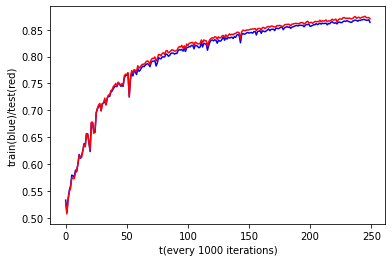

In [120]:
k = 5
N = 50000
learning_rate = 2e-4

W, v, train_acc, test_acc = net(input[:N,], binary_labels[:N], N, k, learning_rate)
print('When k=%d, final test accuracy=%2.2f%%'%(k,test_acc[-1]*100))
plt.figure()
plt.plot(train_acc, color='blue')
plt.plot(test_acc, color='red')
plt.xlabel('t(every 1000 iterations)')
plt.ylabel('train(blue)/test(red)')

When k=40, final test accuracy=92.00%


Text(0, 0.5, 'train(blue)/test(red)')

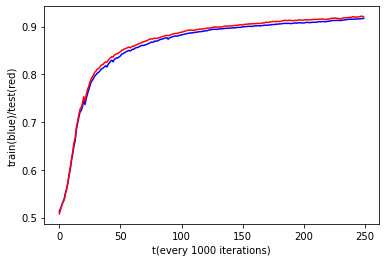

In [110]:
k = 40
N = 50000
learning_rate = 1e-4

W, v, train_acc, test_acc = net(input[:N,], binary_labels[:N], N, k, learning_rate)
print('When k=%d, final test accuracy=%2.2f%%'%(k,test_acc[-1]*100))
plt.figure()
plt.plot(train_acc, color='blue')
plt.plot(test_acc, color='red')
plt.xlabel('t(every 1000 iterations)')
plt.ylabel('train(blue)/test(red)')

When k=200, final test accuracy=94.04%


Text(0, 0.5, 'train(blue)/test(red)')

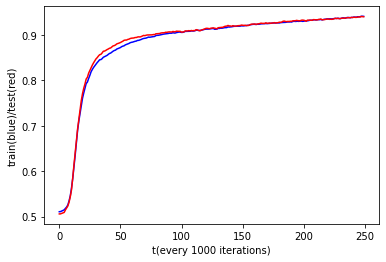

In [109]:
k = 200
N = 50000
learning_rate = 2e-4

W, v, train_acc, test_acc = net(input[:N,], binary_labels[:N], N, k, learning_rate)
print('When k=%d, final test accuracy=%2.2f%%'%(k,test_acc[-1]*100))
plt.figure()
plt.plot(train_acc, color='blue')
plt.plot(test_acc, color='red')
plt.xlabel('t(every 1000 iterations)')
plt.ylabel('train(blue)/test(red)')